# Consigna del desafío 2

- Elegir algún corpus de texto de su preferencia (conviene que sea algo de lo cual ustedes tengan algo de conocimiento al respecto para poder después interpretar la similaridades de embeddings que estudien). Puede ser literatura, texto técnico, blogs, artículos, etc...

- Entrenar embeddings con el  corpus elegido utilizando Gensim. Pueden intentar modificar varios parámetros: tipo de modelo (cbow/skipgram), tamaño de vocabulario, tamaño de ventana de contexto, negative samples (que trataremos de hablar algo porque no hubo tiempo la vez pasada).

- Con alguna de versión de embeddigns que hayan entrenado (o con todas!) estudiar similaridades de términos que crean interesantes. Graficarlos en 2D y si quieren en 3D y destacar casos interesantes para su corpus. Interpretarlos del conocimiento a priori que tengan del corpus.

In [2]:
import pandas as pd
import keras.preprocessing.text
from keras.preprocessing.text import text_to_word_sequence
import string
from nltk.corpus import stopwords
from gensim.models.callbacks import CallbackAny2Vec

from gensim.models import Word2Vec
import multiprocessing

from time import time  # To time our operations

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np   

import plotly.graph_objects as go
import plotly.express as px


Corpus: letras de canciones de Natalia Lafourcade

In [3]:
# ruta del archivo Excel
ruta_archivo = '.\desafio 2\letrasNataliaLaforucadeVersos.xlsx'

# Lee el archivo Excel en un DataFrame de pandas
versos = pd.read_excel(ruta_archivo)

In [4]:
len(versos)

378

In [5]:
versos.head(20)

,Versos
0,"""¿Para qué sufrir si no hace falta?"
1,"""Busco destellos de luces que puedan haceme vo..."
2,"""En el 2000"
3,"""En mi tierra veracruzana"
4,"""Esta historia terminó no existe"
5,"""Ha pasado tanto tiempo"
6,"""Me llaman la malquerida"
7,"""No sé que tienen las flores, llorona"
8,"""Nunca es suficiente para mí"
9,"""Poniendo la mano sobre el corazón"


### Preprocesamiento

In [6]:

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in versos[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['¿para', 'qué', 'sufrir', 'si', 'no', 'hace', 'falta'],
 ['busco', 'destellos', 'de', 'luces', 'que', 'puedan', 'haceme', 'volver']]

In [8]:
tokens_filtrados = []
for sentence in sentence_tokens:
    tokens = [token.lower() for token in sentence]  # Convertir a minúsculas cada palabra de la oración
    tokens_sin_puntuacion = [token for token in tokens if token not in string.punctuation]
    tokens_filtrados.append([token for token in tokens_sin_puntuacion if token not in stopwords.words('spanish')])

# Imprimir tokens filtrados
for tokens in tokens_filtrados:
    print(tokens)



['¿para', 'sufrir', 'si', 'hace', 'falta']
['busco', 'destellos', 'luces', 'puedan', 'haceme', 'volver']
['2000']
['tierra', 'veracruzana']
['historia', 'terminó', 'existe']
['pasado', 'tiempo']
['llaman', 'malquerida']
['sé', 'flores', 'llorona']
['nunca', 'suficiente']
['poniendo', 'mano', 'corazón']
['quede', 'infinito', 'estrellas']
['quiero', 'regalarte', 'estrellas']
['vicio', 'piel', 'puedes', 'desprender']
['acostumbraste']
['juramento', 'promesa', 'fugitiva']
['¡ay', 'ay', 'ay', 'llorona']
['¡ay', 'ay', 'ay', 'llorona']
['¡ay', 'vayas', 'quédate', 'siempre', 'quererme', 'gusta']
['¿cómo', 'evitar', 'fracture', 'mil']
['¿para', 'dejar', 'muera']
['¿para', 'olvidar', 'besos']
['¿para', 'ser', 'fríos', 'si', 'mundo', 'hace', 'sentir', 'casa']
['¿para', 'sufrir', 'si', 'hace', 'falta']
['¿para', 'tirar', 'cartas', 'fotografías']
['continuar', 'camino', 'beso', 'da']
['alma']
['alma']
['todas', 'cosas']
['santo', 'cristo', 'fierro', 'llorona']
['ver', 'ver', 'pasa', 'siguiente', 'd

Crear los vectores (word2vec)

### Entrenar embeddings con el  corpus elegido utilizando Gensim. 

In [9]:

# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [10]:
cores = multiprocessing.cpu_count() # Cuenta la cantidad de nucleos en la compu
cores

8

In [165]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=2,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=10,       # cant de palabras antes y desp de la predicha
                     vector_size=50,       # dimensionalidad de los vectores 
                     negative=3,    # cantidad de negative samples... 0 es no se usa
                     workers= cores,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [166]:
# Obtener el vocabulario con los tokens

t = time()

w2v_model.build_vocab(tokens_filtrados, progress_per=1)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 4)))

Time to build vocab: 0.0001 mins


In [167]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 378


In [168]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 206


In [169]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(tokens_filtrados,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1450.8778076171875
Loss after epoch 1: 1580.8238525390625
Loss after epoch 2: 1368.27294921875
Loss after epoch 3: 1261.4326171875
Loss after epoch 4: 1520.87548828125
Loss after epoch 5: 1466.10205078125
Loss after epoch 6: 1550.9296875
Loss after epoch 7: 1346.294921875
Loss after epoch 8: 1359.73828125
Loss after epoch 9: 1381.3671875
Loss after epoch 10: 1510.8125
Loss after epoch 11: 1458.4140625
Loss after epoch 12: 1489.296875
Loss after epoch 13: 1504.220703125
Loss after epoch 14: 1535.47265625
Loss after epoch 15: 1492.48828125
Loss after epoch 16: 1536.244140625
Loss after epoch 17: 1498.74609375
Loss after epoch 18: 1562.978515625
Loss after epoch 19: 1550.22265625
Loss after epoch 20: 1338.771484375
Loss after epoch 21: 1349.078125
Loss after epoch 22: 1488.7890625
Loss after epoch 23: 1497.7109375
Loss after epoch 24: 1484.984375
Loss after epoch 25: 1491.83984375
Loss after epoch 26: 1459.953125
Loss after epoch 27: 1308.8984375
Loss after epoch 28: 1

Loss after epoch 30: 1444.1875
Loss after epoch 31: 1494.18359375
Loss after epoch 32: 1467.796875
Loss after epoch 33: 1357.65234375
Loss after epoch 34: 1604.625
Loss after epoch 35: 1474.5625
Loss after epoch 36: 1547.171875
Loss after epoch 37: 1446.875
Loss after epoch 38: 1585.77734375
Loss after epoch 39: 1519.72265625
Loss after epoch 40: 1328.30859375
Loss after epoch 41: 1416.6015625
Loss after epoch 42: 1469.3984375
Loss after epoch 43: 1437.67578125
Loss after epoch 44: 1414.40234375
Loss after epoch 45: 1541.3828125
Loss after epoch 46: 1463.9765625
Loss after epoch 47: 1497.4375
Loss after epoch 48: 1517.234375
Loss after epoch 49: 1370.125
Loss after epoch 50: 1385.1171875
Loss after epoch 51: 1493.3828125
Loss after epoch 52: 1451.5859375
Loss after epoch 53: 1507.3828125
Loss after epoch 54: 1367.0078125
Loss after epoch 55: 1448.640625
Loss after epoch 56: 1513.4921875
Loss after epoch 57: 1449.1796875
Loss after epoch 58: 1477.1796875
Loss after epoch 59: 1315.929687

(47451, 117800)

Realicé distintos entrenamientos cambiando los parámetros tanto del modelo como del entranamiento. 

**Resumen de resultados**:

* Se probaron valores de **"min_count"** de 1, 5, 10 y 25.  Entre 1 y 2 no hubo diferencia alguna. Para valores mas grandes de "min_count" se observa que disminuye la cantidad de words distintas en el corpus y se pierden palabras que son significativas en las canciones.

* **cantidad de épocas de entreanamiento**: el valor de la función de pérdida mejoró considereblemente entrenar con 100 epocas en lugar de 20. Esto se vió reflejado en la simulitud entre palabras, las palabras que pertenecen a un mismo verso tienen mayor similitud y en los gráficos se encuentran más cercanas.

* **Windows size** si el tamaño es chico (2, por ejemplo) las palabras similares a una en particular son correctas. Pero en la visualización en 2D esas palabras se encuentran más alejadas respectos de otras. Probando distintos valores de este parámetro, concluyo que es mejor tomar valores mayores (por ejemplo 10, el que usé finalmente).

* **negative words**: al aumentar este parámetro de 2 a 5 mejora la similitud entre palabras de un mismo verso y tambien mejora la no simulitud entre palabras que no pertenecen a mismo verso/contexto. Al probar con un valor de 10 la cantidad de palabras del corpus es cero.

* **sg** (modelo 0:CBOW  1:skipgram). CBOW presentaba en algunos casos un buen entorno de palabras similares y en otros casos no. El valor de simulitud entre palabras de un mismo contexto fue menor que para el caso de skipgram. Considero mejor el uso de skipgram.

**Detalle de resultados**: el detalle del cual surgen las conclusiones anteriores se encuentran en el archivo excel "ceia_PNL_aledp\desafio 2\prueba de cambios en los parámetros"

**Probando el modelo**

In [170]:
# Acceder al vocabulario del modelo Word2Vec
vocabulario = w2v_model.wv.key_to_index

# Obtener las palabras en el vocabulario
palabras_vocabulario = list(vocabulario.keys())

# Imprimir algunas palabras del vocabulario
print("Algunas palabras en el vocabulario:")
print(palabras_vocabulario[:100])  # Cambia el número según tu preferencia



Algunas palabras en el vocabulario:
['quiero', 'llorona', 'amor', 'si', 'ver', 'corazón', 'uh', 'oh', 'solo', 'siempre', 'ay', 'quererme', 'ser', 'nunca', 'día', 'aquí', 'noche', 'cada', 'hu', 'beso', 'acabó', 'cielo', 'campo', 'sabes', 'cómo', '¿para', 'gusta', 'tierra', 'flores', 'tiempo', 'veracruzana', 'vida', 'amores', 'regalarte', 'largo', 'prohibido', 'tan', 'fugitiva', 'dolor', 'alma', 'da', 'volver', 'pasa', 'construimos', 'sentir', 'vayas', 'sensación', 'inocencia', 'aire', 'respiro', 'piel', 'viento', 'hace', 'estrellas', 'penas', 'sigo', 'camino', 'voy', 'bajo', 'verde', 'cuerpo', 'santo', 'poder', 'siguiente', 'infantil', 'aunque', 'así', 'incondicional', 'cantar', 'dentro', 'dueños', 'aprendí', 'sueños', 'busco', 'quedo', 'toda', 'rincón', 'criatura', 'decirte', 'creas', 'quieres', 'remedio', 'malquerida', 'mirar', 'ouh', 'sé', 'llorar', 'quisiera', 'caminar', 'melodías', 'quede', 'enseñaste', 'suficiente', 'tarde', 'nadie', 'negro', '¡ay', 'saber', 'querer', 'ojos']


In [171]:
palabra_seleccionada = "fugitiva"

In [172]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=[palabra_seleccionada], topn=10)

[('largo', 0.9763230085372925),
 ('beso', 0.9754489660263062),
 ('escapó', 0.972010612487793),
 ('sensación', 0.9627436995506287),
 ('volver', 0.9178304076194763),
 ('da', 0.906629204750061),
 ('camino', 0.8938575387001038),
 ('continuar', 0.8869964480400085),
 ('pueda', 0.8792226910591125),
 ('comentar', 0.8719149231910706)]

In [173]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=[palabra_seleccionada], topn=10)

[('palabras', 0.3575252592563629),
 ('tápame', 0.3563496172428131),
 ('mirada', 0.27491769194602966),
 ('volverte', 0.24509941041469574),
 ('café', 0.2016032189130783),
 ('papel', 0.17130714654922485),
 ('caminos', 0.09682723134756088),
 ('alma', 0.047782640904188156),
 ('va', -0.06638617813587189),
 ('miran', -0.08557325601577759)]

In [174]:
# el método `get_vector` permite obtener los vectores:
vector_palabra_seleccionada = w2v_model.wv.get_vector(palabra_seleccionada)
print(vector_palabra_seleccionada)

[ 0.11383679 -0.11275113  0.02209377 -0.0798245   0.02637621 -0.05271168
  0.03565951  0.24243245 -0.05911709 -0.02010958 -0.01541737  0.01672768
  0.17911948  0.20974141 -0.00852341  0.02704439  0.1203318  -0.11581105
 -0.0258488  -0.07633945  0.19153339 -0.12160709  0.0730743  -0.13305292
  0.0372206  -0.10824683 -0.00980114 -0.04838797 -0.01814201  0.01021408
  0.03656271 -0.04118754  0.03884527 -0.00928695  0.01975765 -0.09162595
  0.02049153  0.12159957  0.03370368 -0.01932064  0.2824305  -0.11490789
  0.08113018  0.06949099  0.17316426 -0.09554408 -0.04861167 -0.11504174
  0.16694072  0.10559682]


In [175]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_palabra_seleccionada)

[('fugitiva', 0.9999999403953552),
 ('largo', 0.9763230085372925),
 ('beso', 0.9754489660263062),
 ('escapó', 0.972010612487793),
 ('sensación', 0.9627436995506287),
 ('volver', 0.9178304076194763),
 ('da', 0.906629204750061),
 ('camino', 0.893857479095459),
 ('continuar', 0.8869963884353638),
 ('pueda', 0.8792226910591125)]

### Visualizar agrupación de vectores

In [176]:
                             
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [177]:
# Graficar los embedddings en 2D

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=labels.shape[0]
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show()#renderer="colab") # esto para plotly en colab

In [178]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show()

**Ejemplos destacados**

* verso: "La **fugitiva** **sensación** de un **beso** largo que huye"


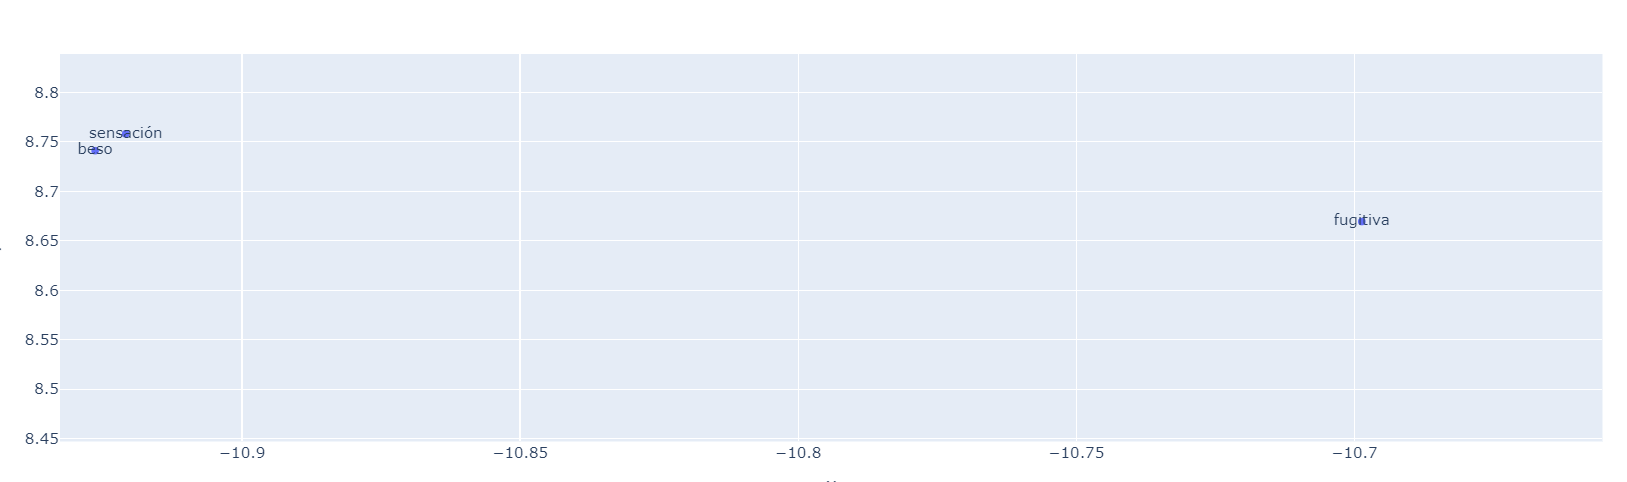

* verso: "En mi **tierra** **veracruzana**"





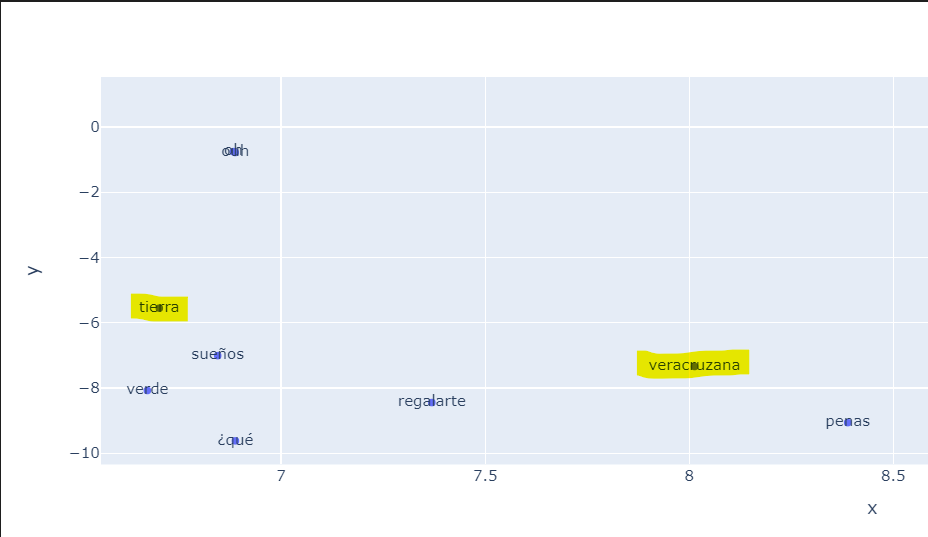


* verso: "Soy lo **prohibido**, soy la **aventura** que llegó para ayudarte"

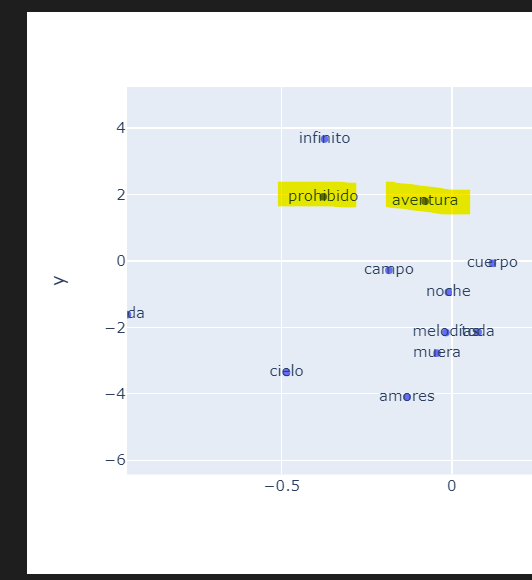